Create a class to represent the lift subsystem.

In [29]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

class LiftSubsystem:
    BOTTOM = 0.0
    MID = 28.0
    TOP = 56.0
    MAX_VEL_IPS = 100.0 # inches per second
    ACCEL_IPS2 = 200.0 # inches per second per second
    H = 0.02  # 20ms period
    MIN_DIST = 1.0
    MIN_VEL = 1.0
    
    def __init__(self):
        self.autoActive = False
        self.autoDistance = 0.0
        self.pos_in = 0.0
        self.vel_ips = 0.0
    
    def setState(self, pos_in=0.0, vel_ips=0.0):
        self.pos_in = pos_in
        self.vel_ips = vel_ips
        self.autoDistance = 0.0;
        self.autoActive = False
        
    def periodic(self):
        if (self.autoActive):
            # print("periodic: autoDistance:{:5.2f}, vel_ips:{:5.2f} ".format(self.autoDistance, self.vel_ips))
            
            if self.autoDistance >= 0:
                # Moving up
                d = self.autoDistance
                v = self.vel_ips
                a = self.ACCEL_IPS2
                up = True
            else:
                # Moving down
                d = -self.autoDistance
                v = -self.vel_ips
                a = self.ACCEL_IPS2
                up = False
                
            t = math.sqrt(2.0*d / self.ACCEL_IPS2)  # time to cover distance, from stop, at max accel
            speed_limit = self.ACCEL_IPS2 * (t - self.H)       # can't go faster than this in this distance
            
            # print("d:{:5.2f} t:{:5.2f} limit:{:5.2f} v:{:5.2f}".format(d, t, speed_limit, v))
            
            # Update velocity
            if ((v >= speed_limit) | (v > self.MAX_VEL_IPS)):
                # Must decel
                v -= self.ACCEL_IPS2*self.H
                # print("decel")
            elif (v + a*self.H < speed_limit) & ((v + a*self.H) < self.MAX_VEL_IPS):
                # May Accel
                v += self.ACCEL_IPS2*self.H
                # print("Accel")
            else:
                # Maintain current speed
                v = v
                # print("Maintain")

            # Update position
            dx = v*self.H
            
            if (up):
                self.autoDistance -= dx
                self.pos_in += dx
                self.vel_ips = v
            else:
                self.pos_in -= dx
                self.autoDistance += dx
                self.vel_ips = -v
            
            # Check for end condition
            if ((abs(self.vel_ips) < self.MIN_VEL) & (abs(self.autoDistance) < self.MIN_DIST)):
                # Auto move is done
                self.autoDistance = 0.0
                self.autoActive = False
    
    def setAutoPosition(self, pos_in):
        # Compute distance to move in auto mode
        self.autoDistance = pos_in - self.pos_in
        self.autoActive = True
    
    def getPosVel(self):
        return (self.pos_in, self.vel_ips)
    
    def getAutoActive(self):
        return self.autoActive
    

Create a class to test the lift.

In [30]:
class LiftTest:
    H = 0.02 # 20ms period
    
    def __init__(self):
        self.lift = LiftSubsystem()
        
    def run(self):
        samples = []
        t = 0.0
        d, v = self.lift.getPosVel()
        samples.append([t, v, d])
        # print("t:{:0.2f} d:{:5.2f} v:{:5.2f}".format(t, d, v))        
        
        while (self.lift.getAutoActive()):
            self.lift.periodic()
            t += LiftTest.H
            d, v = self.lift.getPosVel()
            samples.append([t, v, d])
            # print("t:{:0.2f} d:{:5.2f} v:{:5.2f}".format(t, d, v))   
            
        return samples
    
    def testBottomToMid(self):
        self.lift.setState(LiftSubsystem.BOTTOM)
        self.lift.setAutoPosition(LiftSubsystem.MID)
        return self.run()
    
    def testBottomToTop(self):
        self.lift.setState(LiftSubsystem.BOTTOM)
        self.lift.setAutoPosition(LiftSubsystem.TOP)
        return self.run()
    
    def testMidToTop(self):
        self.lift.setState(LiftSubsystem.MID)
        self.lift.setAutoPosition(LiftSubsystem.TOP)
        return self.run()
    
    def testMidToBottom(self):
        self.lift.setState(LiftSubsystem.MID)
        self.lift.setAutoPosition(LiftSubsystem.BOTTOM)
        return self.run()
    
    def testTopToMid(self):
        self.lift.setState(LiftSubsystem.TOP)
        self.lift.setAutoPosition(LiftSubsystem.MID)
        return self.run()
    
    def testTopToBottom(self):
        self.lift.setState(LiftSubsystem.TOP)
        self.lift.setAutoPosition(LiftSubsystem.BOTTOM)
        return self.run()
        
    def testOvershoot(self):
        self.lift.setState(LiftSubsystem.MID-10, 60.0)
        self.lift.setAutoPosition(LiftSubsystem.MID)
        return self.run()
            
    def testOvershoot2(self):
        self.lift.setState(LiftSubsystem.MID+10, -60.0)
        self.lift.setAutoPosition(LiftSubsystem.MID)
        return self.run()


Run a test


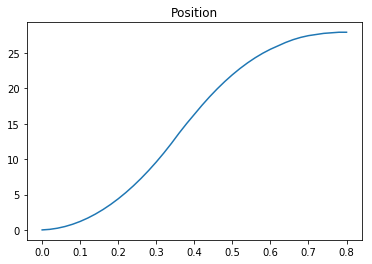

In [32]:
tester = LiftTest()

results = tester.testBottomToMid()
t = [x[0] for x in results]
x = [x[2] for x in results]

plt.plot(t, x)
plt.title('Position')
plt.show()